## Pandas and regression project
## Task:
Predict 'Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)' from other World development indicators
https://datacatalog.worldbank.org/home

### Group 1
https://pypi.org/project/wbgapi/
1. Access world bank data via python API, wbgapi
2. Get the alcohol indicator, and search other indicators (year 2019)
3. Your final product is pandas DataFrame containing 10 relevant indicators of your choice

### Group 2
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html
1. Your input is the DF from the above
2. Solve the problem with missing values (what are you going to do? substitute, invent a value, ignore a country?)
3. Find 5 best candidate predictors of the alcohol comsuption out of the 10 in the table

### Group 3
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
1. Your input is Dataframe with 5 predictors (features) and target alcohol column.
2. Split the data into train and test.
3. prepare a linear regression model (scikit learn LinearRegression()) to fit the data
5. Find evaluation metrics of the model.
6. Predict the test data. How is the performance between train and test?

In [1]:
import wbgapi as wb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn import model_selection
from sklearn import linear_model
from pandas_datapackage_reader import read_datapackage
from tqdm import tqdm
# pip install pandas-datapackage-reader

## Intro to wbgapi

In [2]:
# help for API methods
# help(wb.series)

In [3]:
# fultext search of datasets
# wb.search('alcohol')

In [4]:
# search available series
wb.series.info(q='alcohol')

id,value
SH.ALC.PCAP.FE.LI,"Total alcohol consumption per capita, female (liters of pure alcohol, projected estimates, female 15+ years of age)"
SH.ALC.PCAP.LI,"Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)"
SH.ALC.PCAP.MA.LI,"Total alcohol consumption per capita, male (liters of pure alcohol, projected estimates, male 15+ years of age)"
,3 elements


## Help functions for the DataFrame data

In [5]:
def merge2dfs(df1, df2, on, verbose=1):
    out = df1.merge(df2, on=on)
    if verbose:
        print('Discarded from df2:', set(df1[on]) - (set(out[on])))
    return out

## filter countries from other economic units
def filter_years(data_ID, iso_df, number_years=5, verbose=1):
    """Gets DF from WB by data_ID for the last
    number_years. goes column by column and:
        1. filters valid country ISO codes.
        2. count valid values and tracks which year has
            the most valid values

    Args:
        data_ID (str): WB series ID
        iso_df (pd.DataFrame): DF of valid country isocodes
        number_years (int, optional): number of year columns in the WB dataframe.
            Defaults to 5.
    Returns:
        out (pd.DataFrame): first is economy column (country 3 letter isocode),
            second is year data, containing max valid values.
        
    """
    # query data from WB
    df = wb.data.DataFrame(data_ID, labels=True, mrv=number_years).reset_index()

    # keep only data for independet countries only
    df = df[df['economy'].isin(iso_df['economy'])].reset_index()

    # list of nans per column
    lista = list(df[df.columns[-number_years:]].select_dtypes(include='number').isna().sum())
    # lista = list(df.isna().sum())
    # taking care of datasets with less incomming columns than number_years
    # short version of this code is just number_years = len(lista), because it is either the same
    # meaning no change, or different and number_years is getting changes.
    if len(lista) != number_years:
        # print(f'received only {len(lista)} columns, setting number_years accordingly')
        number_years = len(lista)

    # minimal value for last `number_years columns`
    # TODO: invert list in order to find minimum which is in the newest data, if two minima are the same
    min_nans = int(min(lista[-number_years:]))
    # ::-1 just a bad trick to get index of the last minima (want the most recent datasets, if two minima are the same)
    idx = lista[-number_years:][::-1].index(min_nans)

    # print output controlled by verbose function argument, you can see it quite often
    if verbose:
        print(data_ID, '-- best data collections year:', df.columns[-1-idx], '-- # nans:', min_nans)

    # get the best column
    s = df.columns[-1 - idx]
    # create a resulting DF
    out = df[['economy', s]]

    # rename the year column to data_ID:year
    out = out.rename(columns={s: data_ID + '.' + s[-4:]})
    return  out, min_nans

## setting up

In [6]:
# Get isocodes and continent information for every country
country_codes = read_datapackage("https://github.com/datasets/country-codes")
iso_df = country_codes[country_codes['is_independent']=='Yes'][['ISO3166-1-Alpha-3', 'Continent', 'Sub-region Name', 'CLDR display name']]
iso_df.rename(columns={'ISO3166-1-Alpha-3': 'economy'}, inplace=True)

# if you have geopandas, you can get geographical information too
# geo_countries = read_datapackage("https://github.com/datasets/geo-countries")

## Get the full DF

In [7]:
# get only alcohol dataset
df_target, _ = filter_years('SH.ALC.PCAP.LI', iso_df, 2)

SH.ALC.PCAP.LI -- best data collections year: YR2019 -- # nans: 6


In [8]:
# df_target.head()

In [9]:
# All 1430 dataset IDs
all_data_lst = list(wb.series.list())
len(all_data_lst)

1486

In [10]:
try:
    del df_full
except:
    pass

sel_lst = []
count_bad_datasets = 0
# goes in steps of 10 through all available datasets (takes  7+ mins)
# 1 iteration on my machine takes 3s, for 1400 dataset would take 75mins

# alternatively you can comment out the forloop and load my result of this
df_full = pd.read_csv('DP_good_datasets_all_th03.csv', index_col=0)
# for i, el in tqdm(enumerate(all_data_lst)):  # tqdm used a lot in AI model training
#     try:
#         # some datasets throw errors, that is why I use try except
#         df, nNans = filter_years(el['id'], iso_df, number_years=5, verbose=0)
#         # print(el['id'], df.isna().sum(), df.corrwith(df_target['SH.ALC.PCAP.LI.2010'], axis=0, numeric_only=True))

#         # correlation value of dataset with alcohol consumption
#         corr = abs(df.corrwith(df_target['SH.ALC.PCAP.LI.2019'], axis=0, numeric_only=True).iloc[0])
#     except Exception as e:
#         print('Incomming dataset problem:', e)
#         count_bad_datasets += 1
#         continue
#     if nNans < 5 and corr > 0.3: # tolerate only small amount of nans
#         try:
#             df_full = merge2dfs(df_full, df, on='economy', verbose=0)
#         except:
#             df_full = merge2dfs(iso_df, df, on='economy', verbose=0)   
#         print(f'Taking ({el["id"]}), valid values: {int(df.describe().iat[0, -1])}, corr: {corr}')
#         sel_lst.append(el)

In [11]:
## show correlations
# df_full.head()

In [12]:
# save the df_full
# df_full.to_csv('DP_good_datasets_all_th03.csv')

In [13]:
# remove countries with any nans 
df = df_full[-df_full.isnull().any(axis=1)]
df_target = df_target[-df_target.isnull().any(axis=1)]
# df.head()

In [14]:
# merge target onto the df
df = df.merge(df_target, on='economy')
# df.head()

### TASK: Visualize the correlation matrix

In [15]:
corr = df.corr(numeric_only=True)
# corr

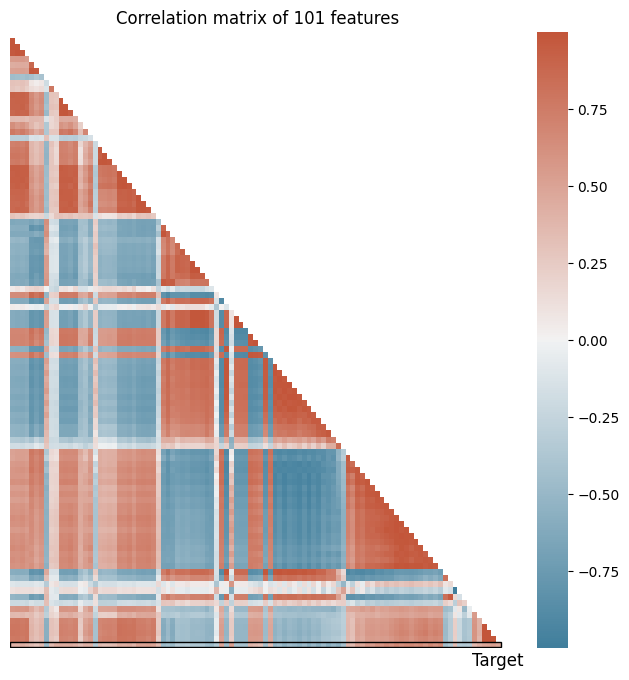

In [16]:
# mask for the upper triangle
import matplotlib.patches as p
mask = np.triu(np.ones_like(corr, dtype=bool))

# matplotlib figure settings
f, ax = plt.subplots(figsize=(8, 8))

# colormap settings
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# creates the heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, yticklabels=False,  xticklabels=False)
plt.title('Correlation matrix of 101 features')
rect = p.Rectangle((0, 101), 101, 0.9, color='k', fill=False, in_layout=False)
ax.add_patch(rect)
ax.text(95, 105, 'Target', fontsize='large')
plt.savefig('figs\\corr_heatmap.png', dpi=180)
plt.show()

In [440]:
# my quickly selected features by eye. Which perform surprisingly well.
df18 = df[['economy', 'Continent', 'Sub-region Name',
         'CLDR display name', 'CC.EST.2022', 'EG.CFT.ACCS.ZS.2021', 'EN.ATM.PM25.MC.M3.2019',
         'ER.PTD.TOTL.ZS.2022', 'GE.PER.RNK.LOWER.2022', 'IT.NET.SECR.P6.2020',
          'NY.GDP.TOTL.RT.ZS.2018', 'RQ.PER.RNK.2022', 'SG.GEN.PARL.ZS.2019',
          'SH.PRG.ANEM.2019', 'SH.STA.DIAB.ZS.2021', 'SP.DYN.CDRT.IN.2018',
          'SP.POP.2024.MA.5Y.2022', 'SP.POP.80UP.FE.5Y.2022', 'TM.VAL.MRCH.HI.ZS.2020',
          'TX.VAL.MRCH.HI.ZS.2020', 'VA.EST.2022', 'SH.ALC.PCAP.LI.2019',
        ]]

In [18]:
# example feature vs alcohol cons plot
# sns.scatterplot(data=df, x="CC.EST.2022", y='SH.ALC.PCAP.LI.2019')
# plt.show()

## Regression on the whole set of features (use df), or subset (use df18)
* illustrative comparison for changing number of features for the linear regression

In [441]:
def plotRegResult(df_test, y_train, y_train_pred, r2_test=None, r2_train=None):
    """Plot train test model performance in two subplots"""
    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(8, 4))
    sns.scatterplot(ax=ax[0], x=df_test['SH.ALC.PCAP.LI.2019'], y=df_test['y_pred'], hue=df_test['Continent'], )#hue='Sub-region Name')
    ax[0].plot(range(15), range(15), 'k')
    ax[0].title.set_text(f'Test: r2={r2_test:0.2f}')

    sns.scatterplot(ax=ax[1], x=y_train, y=y_train_pred)#hue='Sub-region Name')
    ax[1].title.set_text(f'Train: r2={r2_train:0.2f}')
    ax[1].plot(range(15), range(15), 'k')
    plt.show()

def runRegression(DF, test_size=0.2, k=None):
    """Run whole regression from the dataframe, test-train split,
    k-features selector, fit linear regression, make train test predictions,
    calculate r2 score.

    Args:
        DF: dataframe
        test_size (float): ratio of test samples for split
        k (int): If int, defines how many features are selected from the DF. Defaults to None.
    Returns (note, so many return is a bad practice!!):
        df_test (pd.DataFrame): test split part of DF
        y_train: training values, train
        y_train_pred: model predictions from train data
        r2_test: r2 score on test data
        r2_train: r2 score on train data
        X_train, X_test, y_test: Rest of the output from train_test_split()
    """
    # split data into training and testing set
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(DF[DF.columns[4:-1]], DF[DF.columns[-1]],
                                                                            test_size=test_size, random_state=42)
    # scaling data, standard step, but does matter here.
    # scaler = sklearn.preprocessing.StandardScaler()
    # X_train = scaler.fit_transform(X_train)

    if k is not None:
        selector = SelectKBest(r_regression, k=k)
        selector.fit(X_train, y_train)
        X_train = X_train[selector.get_feature_names_out()]
        X_test = X_test[selector.get_feature_names_out()]

    # fit the model
    reg = sklearn.linear_model.LinearRegression()
    reg.fit(X_train, y_train)

    # predict from model, input is only X_test, y_pred should be close to y_test, wchich is so-called ground truth
    y_pred = reg.predict(X_test)
    # making it into a series with correct index
    sy_pred = pd.Series(y_pred, index=X_test.index, name='y_pred')
    
    # merge predictions on test DF
    df_test = DF.merge(sy_pred, left_index=True, right_index=True)
    df_test = df_test.merge(X_test)
    r2_test = sklearn.metrics.r2_score(y_true=df_test['SH.ALC.PCAP.LI.2019'],
                                       y_pred=df_test['y_pred'],
                                       sample_weight=None)
    
    # Train predictions
    # predict from model, input is only X_test, y_pred should be close to y_test, wchich is so-called ground truth
    y_train_pred = reg.predict(X_train)
    # making it into a series with correct index
    sy_train_pred = pd.Series(y_train_pred, index=X_train.index, name='y_train_pred')
    r2_train = sklearn.metrics.r2_score(y_true=y_train,
                                        y_pred=y_train_pred,
                                        sample_weight=None)

    return df_test, y_train, y_train_pred, r2_test, r2_train, X_train, X_test, y_test

In [442]:
# use one, comment out the other
DF = df.copy()  # all 101 features
DF18 = df18.copy()  # subset of 18 hand-picked features

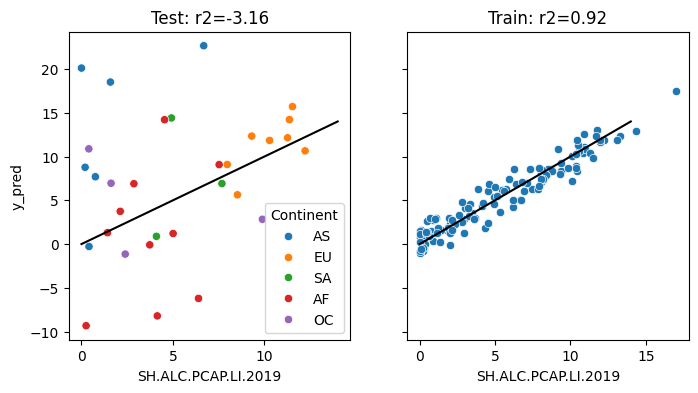

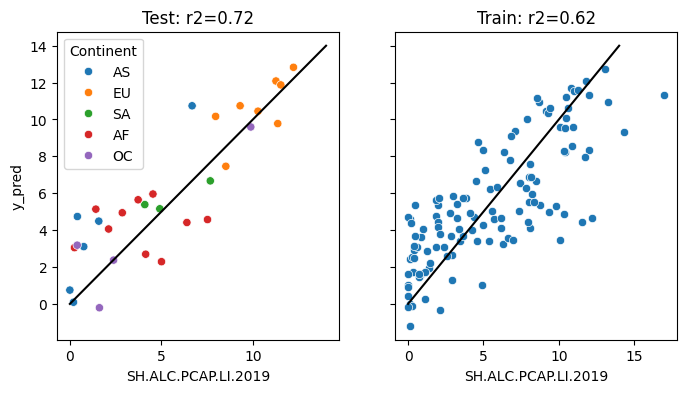

In [443]:
df_test, y_train, y_train_pred, r2_test, r2_train, *_ = runRegression(DF)
# This is where you can see the comparison between the two models.
plotRegResult(df_test, y_train, y_train_pred, r2_test, r2_train)

df_test, y_train, y_train_pred, r2_test, r2_train, *_ = runRegression(DF18)
# This is where you can see the comparison between the two models.
plotRegResult(df_test, y_train, y_train_pred, r2_test, r2_train)

## 02/02: Snippets to get you started with feature selection

In [444]:
# different methods for regression and classification problems exist
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import f_classif, r_regression

selector = SelectKBest(r_regression, k=2)  # selector init 
X_new = selector.fit_transform(X_train, y_train)  # apply transform on data

In [445]:
# data have now k columns
X_new.shape

(122, 2)

In [446]:
# k columns by column name
selector.get_feature_names_out()

array(['SH.UHC.SRVS.CV.XD.2021', 'SP.DYN.CDRT.IN.2018'], dtype=object)

### TASK: Create a loop to Fit regression for increasing k and evaluate r2 score

In [447]:
# storing k, and train/test r2
ks, lst_r2_train, lst_r2_test = [], [], []

# feature selection loop starting from 101 features
for k in range(2, 70):
    df_test, y_train, y_train_pred, r2_test, r2_train, *_ = runRegression(DF, k=k)
    lst_r2_train.append(r2_train)
    lst_r2_test.append(r2_test)
    ks.append(k)

# plt.plot(ks, lst_r2_train, 'o', label='train')
# plt.plot(ks, lst_r2_test, 'o', label='test')
# plt.xlabel('# selected features')
# plt.ylabel('r2 score')
# plt.legend()
# plt.show()

In [448]:
# plotRegResult(df_test, y_train, y_train_pred, r2_test, r2_train)

## Pre-Filter correlation matrix first

In [449]:
# list of column names
cols = list(corr.columns)

# loop over correlation matrix lower tringle and remove highle correlating memebers.
to_remove = []
for i in range(len(cols[:-1])):
    for j in range(0, i):
        if abs(corr.iloc[i, j]) > 0.91: 
            to_remove.append(cols[i])
len(set(to_remove))

72

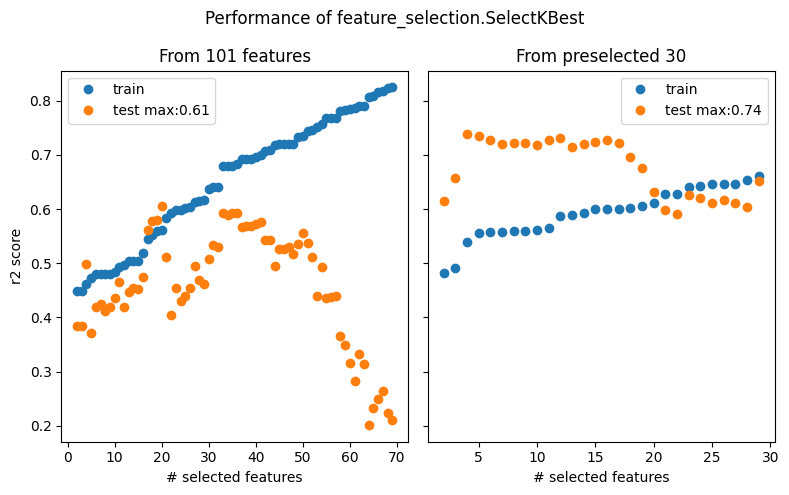

In [450]:
# subplot to compare selectKBest from 101 and preselected features
fig_selector, ax = plt.subplots(1, 2, sharey=True, figsize=(8, 5))

# plot from 101 features
ax[0].plot(ks, lst_r2_train, 'o', label='train')
ax[0].plot(ks, lst_r2_test, 'o', label=f'test max:{max(lst_r2_test):0.2f}')
ax[0].set_xlabel('# selected features')
ax[0].set_ylabel('r2 score')
ax[0].set_title('From 101 features')
ax[0].legend()
# plt.show()

# Drop features which have been selected in pre-filtering
DF_filt = DF.drop(set(to_remove), axis=1)

# again regression for loop using KBest selector on 30 features
ks, lst_r2_train, lst_r2_test = [], [], []
for k in range(2, 30):
    # feature selection and regression
    df_test, y_train, y_train_pred, r2_test, r2_train, X_train, X_test, y_train, y_test = runRegression(DF_filt, k=k)

    # append parameters
    lst_r2_train.append(r2_train)
    lst_r2_test.append(r2_test)
    ks.append(k)

# plot r2 versus k, much nicer, less features needed and better result.
ax[1].plot(ks, lst_r2_train, 'o', label='train')
ax[1].plot(ks, lst_r2_test, 'o', label=f'test max:{max(lst_r2_test):0.2f}')
plt.xlabel('# selected features')
ax[1].set_title('From preselected 30')
# plt.ylabel('r2 score')
plt.legend()
plt.suptitle('Performance of feature_selection.SelectKBest', y=0.98)
plt.tight_layout()
plt.savefig('figs\\feature_selection.png')
plt.show()

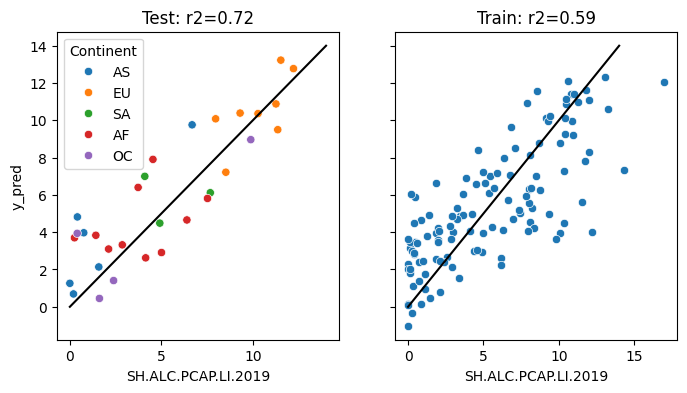

In [451]:
# pick any k and rerun the regression to plot the train/test result.
df_test, y_train, y_train_pred, r2_test, r2_train, X_train, X_test, y_train, y_test = runRegression(DF_filt, k=14)
plotRegResult(df_test, y_train, y_train_pred, r2_test, r2_train)

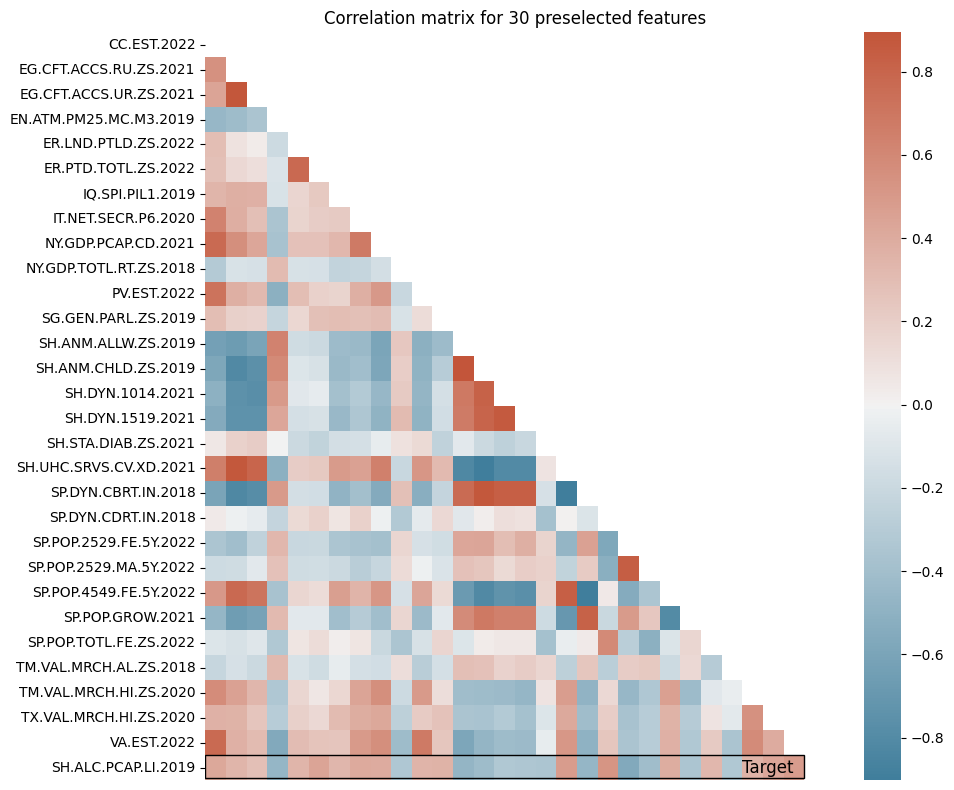

In [452]:
corr2 = DF_filt.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr2, dtype=bool))

# matplotlib figure settings
f, ax = plt.subplots(figsize=(10, 8))

# colormap settings
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# creates the heatmap
sns.heatmap(corr2, mask=mask, cmap=cmap, yticklabels=True,  xticklabels=False)
plt.title('Correlation matrix for 30 preselected features')
rect = p.Rectangle((0, 29), 29, 0.9, color='k', fill=False, in_layout=False)
ax.add_patch(rect)
ax.text(26, 29.7, 'Target', fontsize='large')
plt.tight_layout()
plt.savefig('figs\\corr_heatmap_selector.png', dpi=180)
plt.show()

### We ran everything with the same train/test split
* TASK: Take a look at https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html and implement it into our runRegression func.

### There is something fundamentally wrong on this approach of picking optimal set of features?
* TASK: What is it, and how do we fix it?

### We have seen that continent itself might be a good predictor
* TASK: look into how to create a categorical feature out of continent values.

### Correlation VS. Causation
* TASK: Correlation does not mean causation, which is what we care about. How do we separate those two?